# Overview

Big picture, PsiZ allows us to take some observable behavior (such as similarity judgments) and infer the likely psychological representations people use to perceive the world.

The Beginner Tutorial demonstrates how to create a maximum likelihood estimate (MLE) model from ordinal (i.e., ranked) similarity judgments. The tutorial mimics a simple research pipeline that one would use in a real project. The tutorial aims to teach the basic organization and mechanics of PsiZ, giving readers the background necessary to use PsiZ in their own projects.

PsiZ has been designed to be as flexible as possible and work with many different stimuli. While this tutorial focuses on a dataset of images, PsiZ can be used to model psychological representations of audio files, movies, words, odors and other stimuli. After completing this tutorial you should have a good idea how to redo the modeling using your own dataset.

The tutorial is divided into five parts:

1. Context
2. Data Preparation
3. Model Construction
4. Model Inference
5. Model Analysis

If you would like to run this notebook on your local machine, the file is available at [PsiZ's GitHub](https://github.com/roads/psiz/tree/main/docs/src/beginner_tutorial/beginner_tutorial).

```{note}
The Beginner Tutorial introduces the simplest model for inferring embeddings. An MLE model is a point estimate model and on it's own does not provide information about uncertainty. Readers interested in modeling uncertainty should take a look at variational inference (VI). For intelligent methods for selecting informative trials, take a look at active learning.
```

# Context

Imagine we are interested in understanding how the average person perceives a set of bird images. We would like to know how different species cluster in psychological space, which images show birds that are prototypical of their species, which species have the smallest/largest perceived variability, and what perceptual features are salient or ignored. To begin answering these questions it is useful to have a formal model of people's mental representations. Since people's mental representations are not directly observable, we use statistical inference to infer mental representations that are most likely to explain observable behavior ({numref}`fig-model-flow-0`).

```{figure} ../../img/model_flow_0a.png
---
align: center
name: fig-model-flow-0
alt: Trial and agent inputs feeding into box denoting a cognitive model which outputs behavior. 
---
High-level operation of PsiZ models. Trial and agent information is provided as input to a cognitive model. After internal processing, the model outputs the probability associated with different task behavior. Statistical inference is used to infer the most likely values of the cognitive model parameters.
```

Many tasks can be used to ellicit obserable behavior, but a handful of tasks are particularly popular for probing mental representations. Common tasks for elliciting observable behavior include pairwise rating judgements (e.g., given two images rate on a 1 to 7 scale how similar the images are), triplet similarity judgements (given 1 image, select from the remaining two which is more similar), odd-one-out (given three images, select the image that doesn't belong) and categorization (given an image, provide the category label). Some tasks will be better suited for certain modalities. For example, if judging the similarity between odors, a researcher will need to present the stimuli separately whereas many images can be displayed at once. 

A generalization of the triplet similarity task involves a grid composed of nine images ({numref}`fig-bird-trial-display`). The center image is called the *query* and the surrounding images are called *references*. Instead of selecting just one reference image, the task is to select the two reference images that are most similar to the query and also indicate which choice is more similar. Completing one of these displays constitutes one *ranked 8-choose-2 similarity judgment*.

```{figure} ../../img/bird_trial_display.gif
---
align: center
name: fig-bird-trial-display
alt: Animated GIF showing how participants select reference images given a query image.
---
Recording of an individual completing two ranked similarity trials.
```

The advantage of these many-image trials is that additional information can be collected without requiring much additional time from the participant, reducing data collection cost. Loosely speaking you can imagine that one ranked 8-choose-2 trial contains a similar amount of information as 13 traditional triplet (2-choose-1) trials.

To see why, consider a triplet trial with query stimulus `q` and reference stimuli `a` and `b`. If a participant selects `a` as more similar, we can use a shorthand to denote the outcome of this trial `q: a > b`. In a 8-choose-2 scenario, there are eight references (`a`-`h`). If a participant selects `a` as the most similar and `b` as the second most similar, this implies the following triplet relations:
1. `q: a > b`
2. `q: a > c`
3. `q: a > d`
4. `q: a > e`
5. `q: a > f`
6. `q: a > g`
7. `q: a > h`
8. `q: b > c`
9. `q: b > d`
10. `q: b > e`
11. `q: b > f`
12. `q: b > g`
13. `q: b > h`

If we collect enough trials, we can use all the implied contraints to infer a multidimensional representation of how people perceive the stimuli ({numref}`fig-bird-embedding-3d`). Stimuli that are judged as similar are placed close together in psychological space and stimuli judged as dissimilar are placed far apart. We refer to this kind of representation as a *psychological embedding*. If you give the same trial to different people, you may get different responses (i.e., between-subject variability). The same person might even give different reponses for the same trial (i.e., within-subject variability). The inference procedure will find the embedding that best satisfies all the (potentially noisy) trials.

```{figure} ../../img/birds-16_emb_3d.gif
---
align: center
name: fig-bird-embedding-3d
alt: TODO
---
A 3D psychological embedding of bird images. Each dot represents one image and is color-coded based on species membership.
```

```{note}
It is difficult to predict how many trials will be necessary to obtain a high-quality embedding. There are three factors that influence this number. First, more stimuli necessitate more trials. Second, low within- and between-subject agreement will necessitate more trials. Third, the collection strategy impacts how many trials are necessary. For example, using active learning instead of random trials can greatly reduce the number of trials necessary. Will prediction is hard, evaluation is more straightfoward. After some trials have been collected, one can use a version of Representational Similarity Analysis (RSA) to determine if a sufficient number of trials have been collected. RSA is discussed more in TODO.
```

# Data Preparation

## Basic Setup

We start by importing the major packages we need: `tensorflow` and `psiz`. We also import `os` to adjust environment variables. TensorFlow's (TF) noisy default output is dialed down to a quieter setting that only outputs error messages.

<!-- TODO use CPU, add text discussing this -->

In [3]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf

import psiz


## Load and Partition Dataset
 <!-- TODO section or link on how to wrangle your own data into object -->

<!-- TODO explain mask_zero -->

For this tutorial, we will use a previously collected set of ranked similarity judgments. The judgments were collected while participants viewed sets of bird images. When we import the data using the `psiz.datasets` module, we also import a catalog that maps embedding indices to stimulus information (e.g., filenames and class labels). The loaded observations are partitioned into a train (80%), validation (10%), and test set (10%).

In [15]:
# Load hosted dataset.
(obs, catalog) = psiz.datasets.load_dataset('birds-16', verbose=1)

# Inspect object types.
print("'obs' type: {0}".format(type(obs)))
print("'catalog' type: {0}".format(type(catalog)))


Dataset Summary
  n_stimuli: 208
  n_trial: 16292
'obs' type: <class 'psiz.trials.similarity.rank.rank_observations.RankObservations'>
'catalog' type: <class 'psiz.catalog.catalog.Catalog'>


Taking a look at the `catalog` object, we inspect the `stimuli` attribute to view information about each stimulus. The `stimuli` attribute is a Pandas `DataFrame` object. Most importantly, we can see the `id` (i.e., embedding index) assigned to each image.

In [16]:
catalog.stimuli.head()

,id,filepath,class_id
0,0,Bird/Cardinalidae/Blue_Grosbeak/Blue_Grosbeak_...,2
1,1,Bird/Cardinalidae/Blue_Grosbeak/Blue_Grosbeak_...,2
2,2,Bird/Cardinalidae/Blue_Grosbeak/Blue_Grosbeak_...,2
3,3,Bird/Cardinalidae/Blue_Grosbeak/Blue_Grosbeak_...,2
4,4,Bird/Cardinalidae/Blue_Grosbeak/Blue_Grosbeak_...,2


Next, we can inspect the first 3 trials of the `obs` object. Instead of storing stimuli filenames in the `obs` object, we store stimuli `id`s, which are treated as embedding indices. In a `RankObservations` class, the stimuli indices for each trial are stored following a convention. To explain the convention, let us assuming the following labels for observed 8-choose-2 judgments ({numref}`fig_8-choose-2_label_convention`)): query stimulus (`q`), first chosen reference (`a`), second chosen reference (`b`), and all remaining unchosen references (`c`-`h`). Each 8-choose-2 trial is recorded as `[q, a, b, c, d, e, f, g, h]`.

```{figure} ../../img/8-choose-2_label_convention.png
---
align: center
name: fig_8-choose-2_label_convention
alt: Diagram showing labeling convention of stimuli.
---
Assumed labeling convention for ranked 8-chooose-2 similarity judgment trial.
```

The `n_select` attribute tracks how many references partipants had to choose for the trial.


In [18]:
n_inspect = 3
print('Stimuli indices for each trial:')
print(obs.stimulus_set[0:n_inspect])

print('Number of selected references for each trial:')
print(obs.n_select[0:n_inspect])

Stimuli indices for each trial:
[[121 104 140  62 188  89 200 147  93]
 [174 181 178 169 170 172 175 177 180]
 [ 62  60 199 164 194 117 140 196 155]]
Number of selected references for each trial:
[2 2 2]


<!-- TODO examine data, explain layout, explain placeholder, "When we construct our models in the next section, we will use the 'mask_zero' argument to let the model know it should ignore the placeholder integers. -->

In general, when fitting a model we will want to assess how well a model generalizes to new data and prevent overfitting. To achive this goal we follow standard practice and partition the data into a train, validation, and test set.

In [52]:
# Partition observations.
obs_train, obs_val, obs_test = psiz.utils.standard_split(obs)
print(
    '\nData Split\n  obs_train:'
    ' {0}\n  obs_val: {1}\n  obs_test: {2}'.format(
        obs_train.n_trial, obs_val.n_trial, obs_test.n_trial
    )
)


Data Split
  obs_train: 13033
  obs_val: 1629
  obs_test: 1630


Since we are using the TensorFlow (TF) ecosystem, we convert the data objects into a `tf.data.Dataset` objects. This allows us to seamlessly exploit TF's powerful inference pipeline. The `shuffle` method tells TF how we want to split the data into batches that will be used to update the model parameters. You can learn more by going to [TF's tf.data.Dataset documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

<!-- TODO should this go in training tips and tricks: The choice of `batch_size` is discussed in more detail in the Model Inference section. For now, know that a wide range of values work.-->
```{note}
The `batch_size` is typically chosen to be a power of 2 since this tends to be more efficient for reasons related to computer architecture. In memory-intensive applications, one typically picks the largest possible power of 2 such that the memory footprint of the batch will still fit on the GPUs/TPUs being used. However, you do not want a batch size that is so large that there is only one batch because multiple batches adds noise that helps gradient decent avoid local optimums (an important theoretical properity of stochastic gradient decent). In this application, our memory-footprint is small and a wide range of values work well.
```

In [53]:
# Set the batch_size.
batch_size = 128

# Convert observations to TF dataset.
ds_obs_train = obs_train.as_dataset().shuffle(
    buffer_size=obs_train.n_trial, seed=252, reshuffle_each_iteration=True
).batch(batch_size, drop_remainder=False)
ds_obs_val = obs_val.as_dataset().batch(
    batch_size, drop_remainder=False
)
ds_obs_test = obs_test.as_dataset().batch(
    batch_size, drop_remainder=False
)

# Model Construction

A PsiZ model can be thought of as having a general backback and two types of modules (`fig-model-flow-1`). The first module type is a *psychological embedding* which models how individuals perceive the world. This module includes a conventional embedding (representing the stimuli coordinates in psychological space) and a kernel (i.e., similarity function) that defines how similarity is computed between the embedding coordinates. The second module type is a *task* module. The task module describes how stimulus perception yields the observed task behaviour. These components are intentionally denoted as *modules* because they can be swapped out to in order to learn different flavors of embeddings and predict different tasks.

```{figure} ../../img/model_flow_1.png
---
align: center
name: fig-model-flow-1
alt: More detailed diagram of cognitive model showing psychological embedding and task behavior modules.
---
A more detailed diagram of PsiZ model design. A PsiZ model has two primary components: a *psychological embedding* module and a *task* module. 
```

```{note}
It is good practice to encapsulate your model construction code in a separate function. Such a function makes it easy to create multiple model instances. Writing the function with an `n_dim` argument is useful for scripts that use cross-validation to determine the optimal dimensionality. An optional `seed` argument is useful for managing reproducibility.
```

In [54]:
def build_model(n_stimuli, n_dim, seed=None):
    """Build model.

    Arguments:
        n_stimuli: Integer indicating the number of stimuli in the
            embedding.
        n_dim: Integer indicating the dimensionality of the embedding.
        seed (optional): Control initialization of embedding layer.

    Returns:
        model: A TensorFlow Keras model.

    """
    # Create an `Embedding` layer that contains free parameters representing
    # the psychological coordinates of the stimuli. By default, the coordinate
    # parameters are randomly initialized according to a uniform distribution.
    stimuli = tf.keras.layers.Embedding(
        n_stimuli + 1, n_dim, mask_zero=True,
        embeddings_initializer=tf.keras.initializers.RandomUniform(seed=seed)
    )

    # Create a similarity kernel that computes the similarity between
    # coordinates in psychological space. In principle, parameters governing
    # the kernel can be learned from the data. For this tutorial we assume
    # L2 distance (i.e., Euclidean distance) and similarity that decays
    # exponentially.
    # TODO more about Sheperd, beta=10?
    kernel = psiz.keras.layers.DistanceBased(
        distance=psiz.keras.layers.Minkowski(
            rho_initializer=tf.keras.initializers.Constant(2.),
            w_initializer=tf.keras.initializers.Constant(1.),
            trainable=False
        ),
        similarity=psiz.keras.layers.ExponentialSimilarity(
            beta_initializer=tf.keras.initializers.Constant(10.),
            tau_initializer=tf.keras.initializers.Constant(1.),
            gamma_initializer=tf.keras.initializers.Constant(0.),
            trainable=False,
        )
    )

    # Pass component layers to a `Rank` model.
    model = psiz.keras.models.Rank(stimuli=stimuli, kernel=kernel)
    return model

In this tutorial we will infer a two-dimensional embedding since our goal is to obtain a convenient visualization. When inferring an embedding that is meant to serve as more than a visualization, it is important to select the dimensionality in a principled manner (e.g., via cross-validation).

We create two models with identical architectures but different weight initializations in order to demonstrate 1) how different initializations impact inference and 2) provide us with two models to explore during analysis.

In [55]:
# Set the number of dimensions for the embedding.
n_dim = 2

# Instantiate two models using different seeds.
model_0 = build_model(catalog.n_stimuli, n_dim, seed=0)
model_1 = build_model(catalog.n_stimuli, n_dim, seed=3)

# Model Inference

<!-- TODO epochs -->
<!-- TODO compile arguments -->
<!-- TODO callbacks in general and early stopping https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback , explain why 1000 epochs, why monitor val-->
<!-- TODO define a training routine -->
<!-- Note that inference is slow when running this code in a Jupyter notebook. -->

In [56]:
def train_routine(model, ds_obs_train, ds_obs_val, ds_obs_test):
    """Run training routine.
    
    Arguments:
        model: A PsiZ model.
    
    Returns:
        metrics: A dictionary of metrics.

    """
    epochs = 1000

    compile_kwargs = {
        'loss': tf.keras.losses.CategoricalCrossentropy(),
        'optimizer': tf.keras.optimizers.Adam(learning_rate=.001),
        'weighted_metrics': [
            tf.keras.metrics.CategoricalCrossentropy(name='cce')
        ]
    }

    # Define an early stopping callback.
    early_stop = psiz.keras.callbacks.EarlyStoppingRe(
        'val_cce', patience=30, mode='min', restore_best_weights=True  # TODO cce or loss?
    )
    callbacks = [early_stop]

    model.compile(**compile_kwargs)
    history = model.fit(
        x=ds_obs_train, validation_data=ds_obs_val, epochs=epochs,
        callbacks=callbacks, verbose=0
    )
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]

    test_metrics = model.evaluate(
        ds_obs_test, verbose=0, return_dict=True
    )
    test_loss = test_metrics['loss']

    print(
        'Metrics\n'
        '    train_loss: {0:.3f}\n'
        '    val_loss: {1:.3f}\n'
        '    test_loss: {2:.3f}\n'.format(train_loss, val_loss, test_loss)
    )
    metrics = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'test_loss': test_loss
    }
    return metrics  # TODO return results

metrics_0 = train_routine(model_0, ds_obs_train, ds_obs_val, ds_obs_test)
metrics_1 = train_routine(model_1, ds_obs_train, ds_obs_val, ds_obs_test)

Metrics
    train_loss: 1.714
    val_loss: 1.884
    test_loss: 1.731

Metrics
    train_loss: 1.730
    val_loss: 1.891
    test_loss: 1.741



After training and evaluation, we can see that the two models have very similar losses. Based on these coarse metrics, the two models are equally capable of fitting seen data and predicting unseen data.

# Model Analysis

TODO

In [60]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

## Embedding Visualization

[]

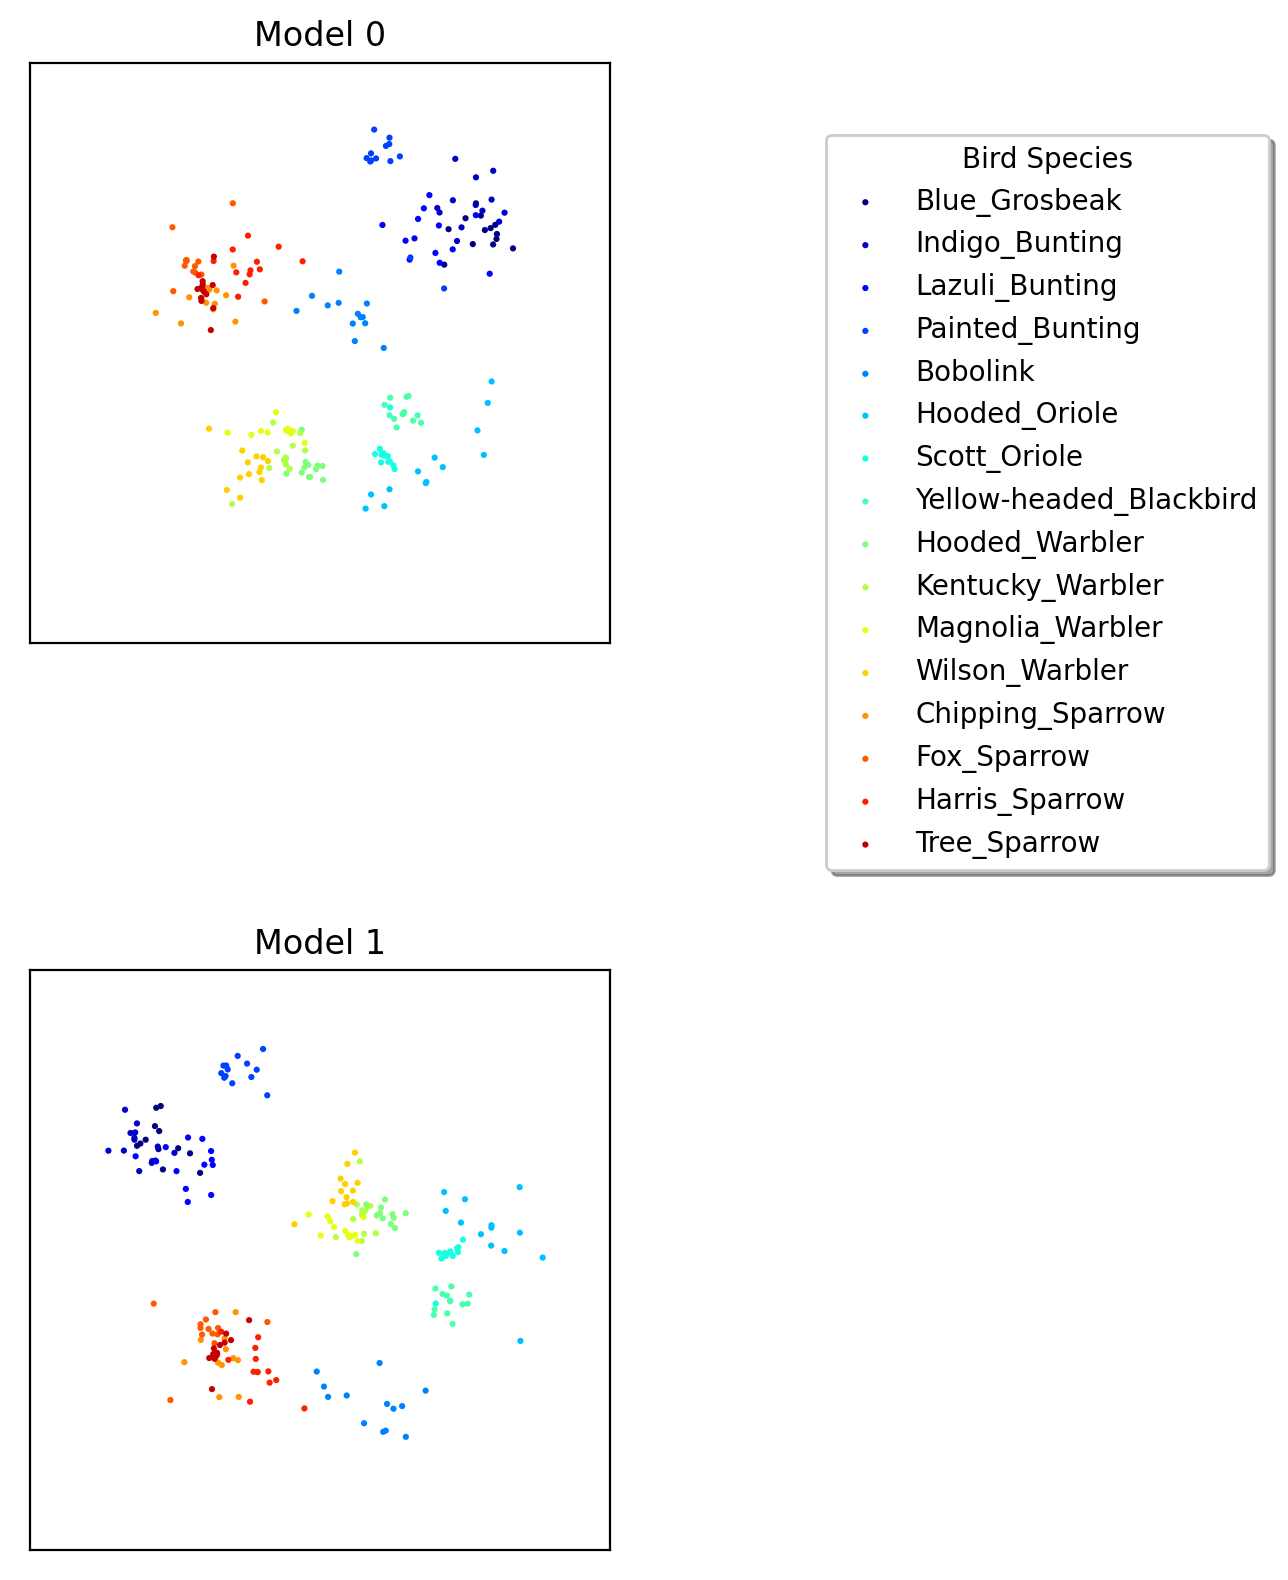

In [58]:
def plot_embedding(fig, model, catalog):
    """Plot embedding."""
    # Settings
    s = 5

    class_arr = catalog.stimuli.class_id.values
    unique_class_arr = np.unique(class_arr)

    # Define one color per class for plots.
    n_class = len(unique_class_arr)
    cmap = matplotlib.cm.get_cmap('jet')
    norm = matplotlib.colors.Normalize(vmin=0., vmax=n_class)
    class_color_array = cmap(norm(range(n_class)))

    # Grab embedding coordinates.
    loc = model.stimuli.embeddings.numpy()
    if model.stimuli.mask_zero:
        # Drop placeholder stimulus.
        loc = loc[1:]

    # Determine embedding limits.
    z_max = 1.3 * np.max(np.abs(loc))
    z_limits = [-z_max, z_max]

    # Draw stimuli modes with exemplar color-coded by class membership.
    exemplar_color_array = class_color_array[squeeze_indices(class_arr)]
    for idx_class in unique_class_arr:
        bidx_class = np.equal(class_arr, idx_class)
        class_label = catalog.class_label[idx_class]
        ax.scatter(
            loc[bidx_class, 0], loc[bidx_class, 1], s=s,
            c=exemplar_color_array[bidx_class], marker='o', edgecolors='none',
            zorder=100, label=class_label
        )

    ax.set_xlim(z_limits)
    ax.set_ylim(z_limits)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])


def squeeze_indices(idx_arr):
    """Squeeze indices of array."""
    uniq_idx_arr = np.unique(idx_arr)
    idx_arr_2 = np.zeros(idx_arr.shape, dtype=int)
    for counter, uniq_idx in enumerate(uniq_idx_arr):
        loc = np.equal(idx_arr, uniq_idx)
        idx_arr_2[loc] = counter
    return idx_arr_2


# Create visual.
fig = plt.figure(figsize=(6.5, 8), dpi=200)
gs = fig.add_gridspec(2, 1)

ax = fig.add_subplot(gs[0, 0])
plot_embedding(ax, model_0, catalog)
ax.set_title('Model 0')
ax.legend(bbox_to_anchor=(1.35, 0.9), shadow=True, title="Bird Species")

ax = fig.add_subplot(gs[1, 0])
plot_embedding(ax, model_1, catalog)
ax.set_title('Model 1')

gs.tight_layout(fig)
plt.plot()

Notice that the two models---which we already confirmed have similar losses---appear to have different solutions. Even after applying an affine transformation (translation, scaling, rotation) to make the two solutions as similar as possible, there is still a qualitative difference. In `Model 0` the yellow dots are far away from the dark blue dots, but in `Model 1` the yellow dots are near the dark blue dots. While this seems like an huge difference from the perspective of L2 (Eulcidean) distance, it is important to remember that similarity (not distance) is the critical quality. In these models, similarity decays exponentially with increasing distance. This means that two stimuli that are moderately far apart and extremely far apart will both have a small similarity.


## Similarity Analysis

Instead of comparing the coordinate locations, we can instead compare the pairwise similarity matrices of the two models by computing the Pearson correlation between the two *unrolled* similarity matrices. By comparing the pairwise similarity models we can evaluate the extent that the models exhibit any *meaningful* differences. This kind of analysis has been around a long time in psychology. For example, Sheperd framed this analysis as focusing on second-order isomorphism (similarity matrix equivalency) rather than focusing on first-order isomorphism (coordinate equivalency). Today, cognitive scientists often refer to this kind of analysis as representational similarity analysis (RSA).
<!-- TODO refs for above -->

Since our similarity function is symmetric (`s(z_0,z_1) = s(z_1, z_0)`) we will only compute the upper triangular portion of the pairwise similarity matrix. We omit the diagonal because these values will all be 1 and will artificially skew our assessment.

```{note}
In general, computing a pairwise similarity matrix is expensive in terms of computational cost and storage cost. While the costs are minimal for this small stimulus set, PsiZ is designed to scale to large problems. For this reason, pairwise similarity is computed using a batch strategy.
```

In [59]:

# Assemble a TF Dataset of pairwise indices that will be used to compute
# "unrolled" similarity matrices.
ds_pairs, ds_info = psiz.utils.pairwise_index_dataset(
    np.arange(catalog.n_stimuli) + 1, elements='upper'
)

# The "unrolled" similarity matrix of `Model 0`.
simmat_0 = psiz.utils.pairwise_similarity(
    model_0.stimuli, model_0.kernel, ds_pairs
).numpy()

# The "unrolled" similarity matrix of `Model 1`.
simmat_1 = psiz.utils.pairwise_similarity(
    model_1.stimuli, model_1.kernel, ds_pairs
).numpy()

rho, _ = pearsonr(simmat_0, simmat_1)
print('Pearson rho: {0:.2f}'.format(rho))

Pearson rho: 0.95


The high Pearson correlation reveals that what initially seemed like a big difference between the two solution, is only a minor.

<!-- TODO Exercises: Create a new 2D embedding of rocks,  -->